In [1]:
%%capture
!pip install tensorflow-datasets==4.8 --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-text==2.15.0 --quiet #15
!pip install pydot --quiet
!pip install transformers==4.17 --quiet
!pip install -U scikit-learn

In [2]:
#Tensorflow libiries
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds

#Transformers - BERT from huggingface
from transformers import BertTokenizer, TFBertModel
from transformers import logging
logging.set_verbosity_error()
from transformers import AutoConfig
from tensorflow.keras.callbacks import EarlyStopping

#NLP libiries
import sklearn as sk
from sklearn.metrics import classification_report
import os
import nltk
from nltk.data import find

#data process
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
import pandas as pd
import math
from bs4 import BeautifulSoup
import os
import json


In [3]:
#loading the pre-trained tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

In [4]:
#load the dataset with error handling
try:
    train_df = pd.read_csv('full_train_data(Revised).csv')
except pd.errors.ParserError as e:
    print(f"Error reading CSV: {e}")
    # Print the lines around the problematic row
    with open('full_train_data(Revised).csv', 'r') as f:
        lines = f.readlines()
        for i in range(17622, 17626):
            if i < len(lines):
                print(lines[i])

test_df = pd.read_csv('full_test_data(Revised).csv')

# Adjust pandas display settings to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full content of each column
pd.set_option('display.width', None)  # Auto-detect width of the display




In [ ]:
train_df.head(1)

,title,date,content_original,bias,bias_text,source
0,"carly fiorina squanders momentum, slip republican debate?s main stage",2016-01-13,"carly fiorina remains beloved eye many gop voter squandered momentum earned shining debate performance last summer, limp new year hoping lastminute miracle presidential primary. after clawed way onto main stage debate september, sole woman republican field relegated second tier thursday’s debate south carolina. the fiorina camp downplaying snub, insisting there’s still time sway huge swath primary voter say haven’t firmly committed candidate. poll don’t decide elections, neither medium executives. voter do,” anna epstein, campaign spokesperson, said. voter frustrated political class failed year year.",2,right,Washington Times


In [ ]:
print(f"basic train_df info: ",train_df.shape)

basic train_df info:  (20114, 6)


In [ ]:
test_df.head(1)

title        date  \
0  president obamas supreme court shortlist leaked. 6 contenders.  2016-03-12   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [ ]:
print(f"basic test_df info: ",test_df.shape)

basic test_df info:  (5029, 6)


In [5]:
#fine tuning the BERT model with the news article training set's first 6 sentences only
import nltk
from nltk.tokenize import sent_tokenize

def extract_first_six_sentences(text):
    # Download the punkt tokenizer if not already available
    nltk.download('punkt', quiet=True)

    # Tokenize the text into sentences
    sentences = sent_tokenize(text)

    # Get the first 6 sentences
    first_five = sentences[:6]

    # Join the sentences back into a single string
    result = ' '.join(first_five)

    return result

train_df['content_original']=train_df['content_original'].apply(extract_first_six_sentences)

In [6]:
# extract the train and test text from both dataframes
train_text = train_df['content_original']
train_text_labels = train_df['bias']

validate_text = test_df['content_original'][0:2000]
validate_text_labels = test_df['bias'][0:2000]

test_text = test_df['content_original'][2000:]
test_text_labels = test_df['bias'][2000:]


print(f"size of training dataset: ",len(train_text))
print()
print(f"size of valid dataset: ",len(validate_text))
print()
print(f"size of testing dataset: ",len(test_text))
print()
print(f"Left with Label 0 ")
print(f"Center with Label 1 ")
print(f"Right with Label 2 ")

size of training dataset:  20114

size of valid dataset:  2000

size of testing dataset:  3029

Left with Label 0 
Center with Label 1 
Right with Label 2 


In [7]:
MAX_SEQUENCE_LENGTH = 512

In [8]:
# tokenize the dataset, truncate at `max_length`,

#tokenizing the train text
x_train = bert_tokenizer(train_text.tolist(),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_train = train_text_labels

#tokenizing the validate text
x_validate = bert_tokenizer(validate_text.tolist(),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_validate = validate_text_labels


#tokenizing the test text
x_test = bert_tokenizer(test_text.tolist(),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_test = test_text_labels

In [9]:
#BERT base uncased model configurations
config = AutoConfig.from_pretrained('bert-base-uncased')

config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#BERT Uncase Model Fine-Tuning with the News Articles' First 6 Sentences

In [11]:
def create_bert_classification_model(bert_model,
                                     num_train_layers=0,
                                     num_classes = 3,
                                     hidden_size = 768,
                                     dropout=0.3,
                                     attention_probs_dropout_prob = 0.2,
                                     hidden_dropout_prob=0.25,
                                     #lstm_units=90,
                                     learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes
    """
    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_model.trainable = True

    else:
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(num_train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)


        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    #pooler_token = bert_out[1]
    cls_token = bert_out[0][:, 0, :]

    hidden_1 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_1')(cls_token)
    hidden_1 = tf.keras.layers.Dropout(dropout)(hidden_1)


    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden_1)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [12]:
#let's get a fresh instance of the bert_model -- good practice
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_classification_model = create_bert_classification_model(bert_model, num_train_layers=12)

In [13]:
#confirm all layers are frozen
bert_classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 512)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                      

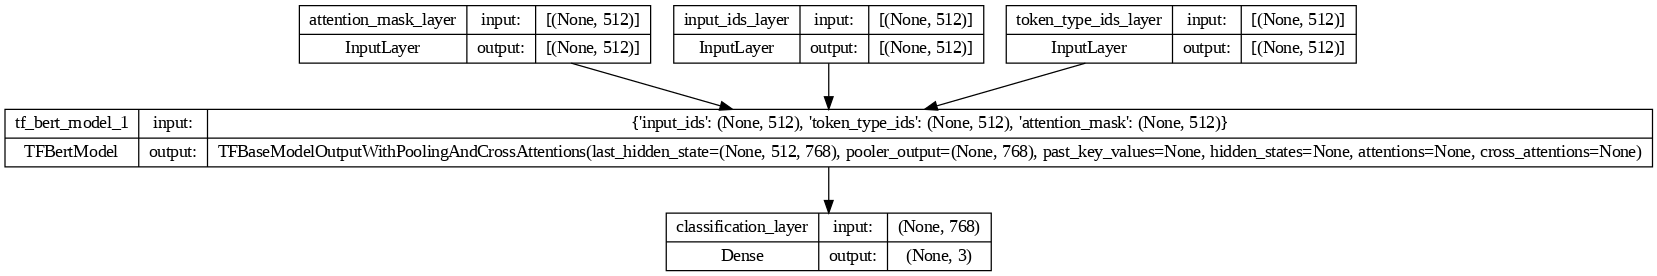

In [ ]:
keras.utils.plot_model(bert_classification_model, show_shapes=True, dpi=90)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
# Early stopping callback to avoid overfitting issue
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=1,
    mode='max',
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [15]:
bert_classification_model_history = bert_classification_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train,
    validation_data=([x_validate.input_ids, x_validate.token_type_ids, x_validate.attention_mask], y_validate),
    batch_size=32,
    epochs=4,
    callbacks=[early_stopping]
)

Epoch 1/4


629/629 [==============================] - 567s 839ms/step - loss: 0.5753 - accuracy: 0.7496 - val_loss: 0.4116 - val_accuracy: 0.8545
Epoch 2/4
629/629 [==============================] - 524s 833ms/step - loss: 0.3665 - accuracy: 0.8569 - val_loss: 0.3998 - val_accuracy: 0.8760
Epoch 3/4
629/629 [==============================] - 524s 833ms/step - loss: 0.2420 - accuracy: 0.9122 - val_loss: 0.3544 - val_accuracy: 0.8845
Epoch 4/4
629/629 [==============================] - 524s 833ms/step - loss: 0.1421 - accuracy: 0.9510 - val_loss: 0.4618 - val_accuracy: 0.8660


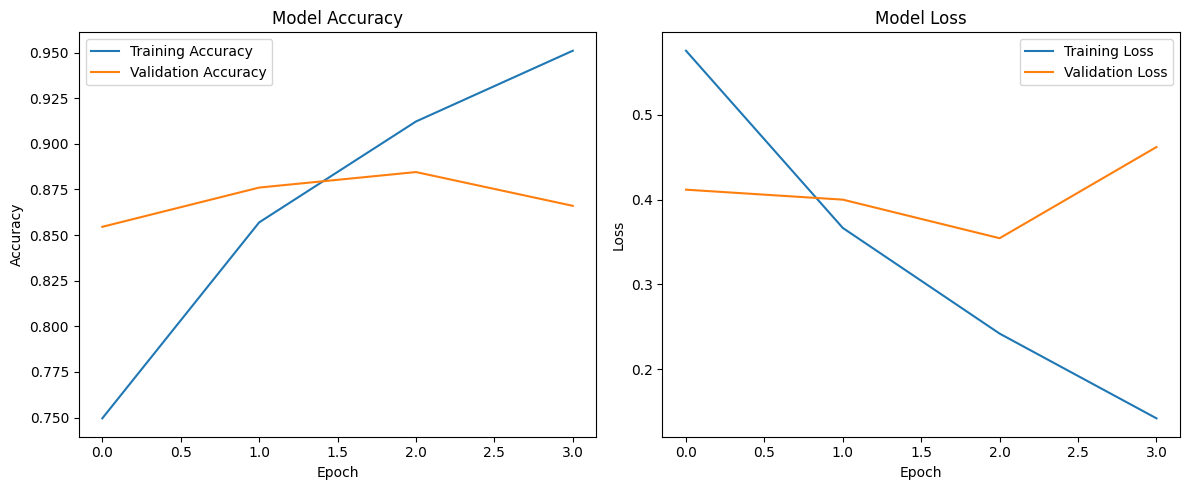

In [16]:
history = bert_classification_model_history.history

# Plotting accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1,2,2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Fine-Tuned BERT model overall prediction score
score = bert_classification_model.evaluate([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask],
                                                  y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

95/95 [==============================] - 25s 265ms/step - loss: 0.4132 - accuracy: 0.8603
Test loss: 0.4132268726825714
Test accuracy: 0.8603499531745911


In [17]:
predictions_model= bert_classification_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])
predictions_model = tf.argmax(predictions_model, axis=-1)
predictions_model

95/95 [==============================] - 28s 260ms/step


<tf.Tensor: shape=(3029,), dtype=int64, numpy=array([1, 1, 2, ..., 2, 2, 0])>

In [18]:
print(classification_report(y_test, predictions_model.numpy(),
                            target_names=['Left ','Center','Right']))

              precision    recall  f1-score   support

       Left        0.91      0.87      0.89      1263
      Center       0.88      0.86      0.87       688
       Right       0.83      0.88      0.86      1078

    accuracy                           0.87      3029
   macro avg       0.87      0.87      0.87      3029
weighted avg       0.87      0.87      0.87      3029



In [19]:
def plot_confusion_matrix(y_true, y_pred, label_names):
    cm = tf.math.confusion_matrix(y_true, y_pred)
    cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

    plt.figure(figsize=(20,7))
    sns.heatmap(
        cm, annot=True,
        xticklabels=label_names,
        yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")

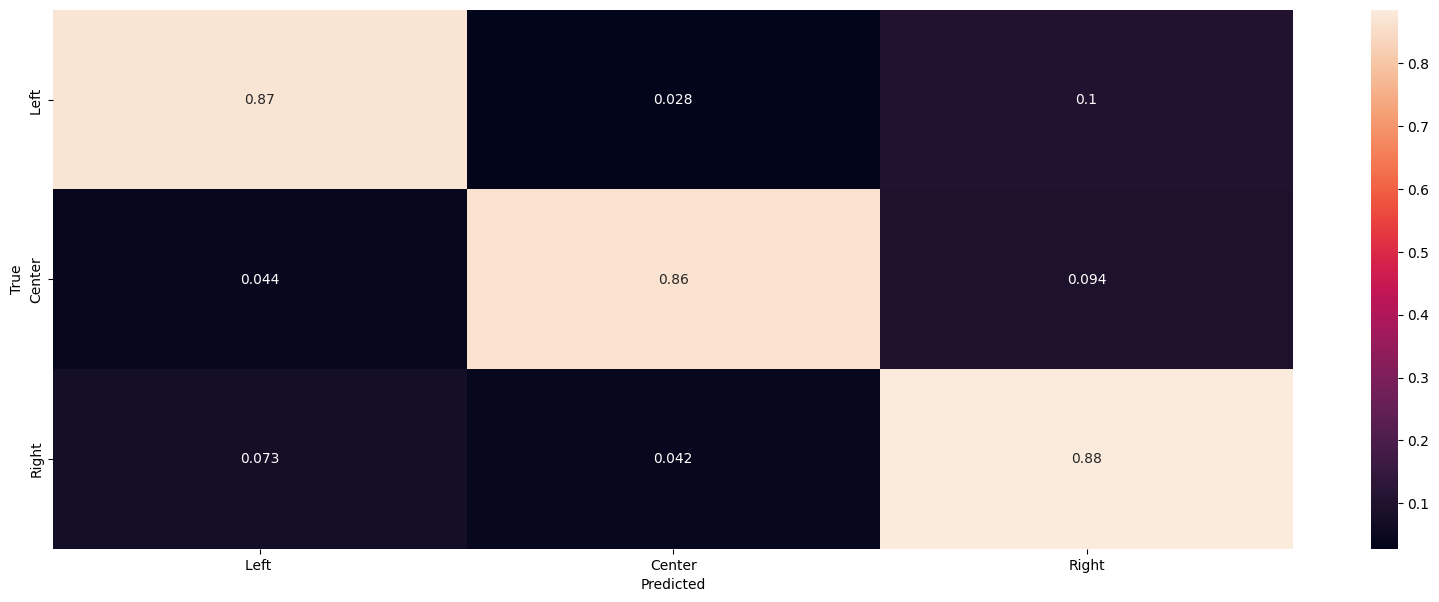

In [20]:
target_names=['Left ','Center','Right']
plot_confusion_matrix(y_test, predictions_model.numpy(), target_names)

In [22]:
bert_first_paragraph_cls_wrong_guesses = np.where(y_test != predictions_model.numpy())

In [23]:
print(f'Number of Wrong Guesses: ',len(bert_first_paragraph_cls_wrong_guesses[0]))

Number of Wrong Guesses:  385


In [24]:
#sampling 20 of the wrong precditions
wrong_guesses = [i for i in np.squeeze(bert_first_paragraph_cls_wrong_guesses[0])]
decoded_wrong_guesses_text=[]

for i in wrong_guesses[:]:
  decoded_text = bert_tokenizer.decode(x_test['input_ids'][i], skip_special_tokens=True)

  # print("Input text:")
  # print(decoded_text)
  decoded_wrong_guesses_text.append(decoded_text)
  # print("True label:")
  # print(y_test.iloc[i])
  # print("Predicted label:")
  # print(predictions_model.numpy()[i])

  # print("-" * 50)



In [25]:
len(decoded_wrong_guesses_text)

385

In [26]:
sources_analysis = test_df.loc[wrong_guesses]

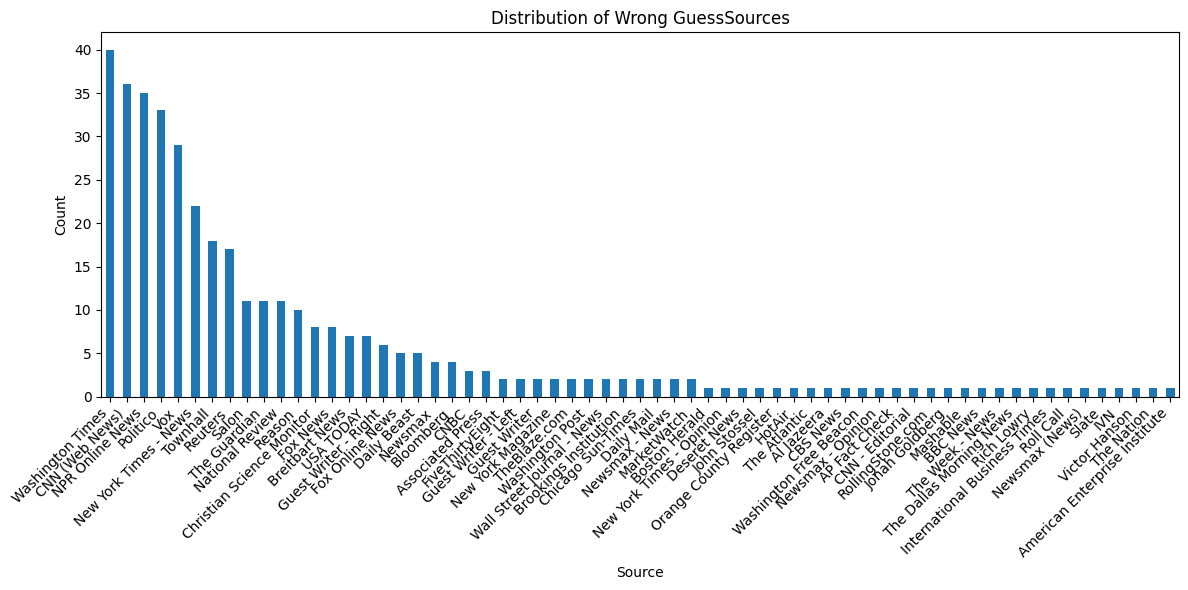

In [27]:
sources_analysis['source']
# Count the occurrences of each source
source_counts = sources_analysis['source'].value_counts()

# Create a bar plot
plt.figure(figsize=(12, 6))
source_counts.plot(kind='bar')

# Customize the plot
plt.title('Distribution of Wrong Guess''Sources')
plt.xlabel('Source')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

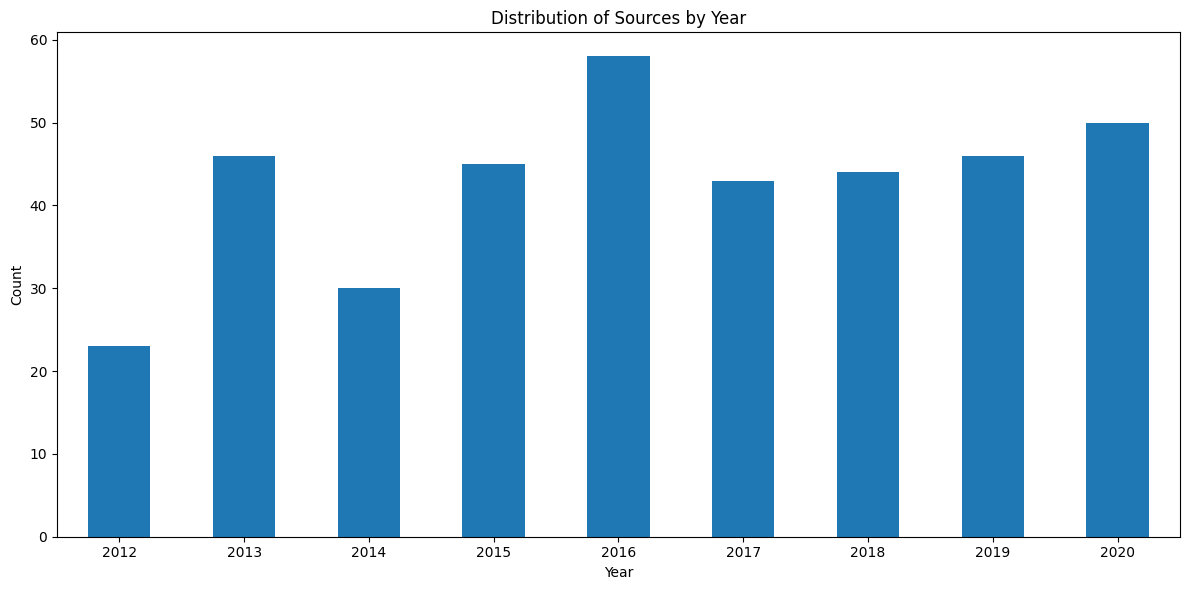

In [28]:
# Convert 'date' to datetime if it's not already
sources_analysis['date'] = pd.to_datetime(sources_analysis['date'])

# Extract year from the date
sources_analysis['year'] = sources_analysis['date'].dt.year

# Count occurrences of each year
year_counts = sources_analysis['year'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(12, 6))
year_counts.plot(kind='bar')

# Customize the plot
plt.title('Distribution of Sources by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=0)  # No rotation for years
plt.tight_layout()

# Show the plot
plt.show()

In [29]:
for i in wrong_guesses[:50]:
  decoded_text = bert_tokenizer.decode(x_test['input_ids'][i], skip_special_tokens=True)

  print("Input text:")
  print(decoded_text)
  print("True label:")
  print(y_test.iloc[i])
  print("Predicted label:")
  print(predictions_model.numpy()[i])

  print("-" * 50)


Input text:
the stage set battle group walmart wmt the unionbacked group walmart expects thousand worker participate protest planned week. employee ask country largest employer end call retaliation speaking better pay, fair schedule affordable health care. such retaliation include shuffling around shifts, cutting hour moving around departments. walmart say protester make handful 1. 3 million workforce. in effort stop them, walmart filed complaint last week national labor relation board, claiming united food commercial worker union subsidiary known ourwalmart unlawfully organized picket line demonstration past six months. retailer said action disrupted business, worker ongoing action violate national labor relation act, prohibits picketing period 30 day without filing petition form union. related : suck work black friday representative federal agency currently holding talk walmart headquarters bentonville, arkansas, complaint. nancy cleeland, spokeswoman agency, said email decision agen

In [31]:
sources_analysis.to_csv('bert_first_paragraph_cls_fine_tuning_wrong guess(7.24.24).csv', index=False)